# TP 1 Big Data : Risque empirique/ Risque de population

# Dani Halegua et Luca Champesting

#### Le but de ce TP est d'implémenter en python le calcul de $\hat C_p$ et mesurer la différence avec entre le risque $R_{emp}(\mathbb{1}_{\hat C_p})$ évalué sur l'échantillon et le risque de population $R(\mathbb{1}_{\hat C_p})$

On dispose des données suivantes :
 - $f_{g,s}(x) = \sum_{i=1}^{n} exp (-\frac {|x-g_i|^2}{2 s_i^2}) $
 - $ A = \left\{  x \in [0,1]^2 | f_{g,s}(x) > \frac {1} {2} \right\} $
 - $ (g_i)_{1 \leq i \leq n} $ tirés au hasard uniformément dans le carré $[0.2,0.8] ^2 $
 - $ (s_i)_{1 \leq i \leq n} $ tirés au hasard uniformément dans l'intervalle $[0,a] $

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
def f(g,s,x1,x2):                                       #Définit la fonction f
    x=[x1,x2]
    n=g.shape[0]
    somme=0
    for i in range(n):
        somme += np.exp(-((np.linalg.norm(x-g[i]))**2)/(2*(s[i])**2))
    return somme
        
        

def isinA (g,s,x1,x2):                   #Pour savoir si un point x appartient à A
    if f(g,s,x1,x2) > 0.5 :
        return 1
    else:
        return -1
        
        
    

def intens(x1,x2,g,s):
    Y = []
    for i in range (len(x1)):
        Y += [isinA(g,s,x1[i],x2[i])]
    return Y
    

In [4]:
a=0.3
n=4
g=np.random.uniform(0.2,0.8,(n,2))
s=np.random.uniform(0,a,n)
x1=[0.4,0.8,0.87,0.76,0.99]
x2=[0.4,0.09,0.87,0.76,0.01]
intens(x1,x2,g,s)




[1, -1, -1, -1, -1]

In [5]:
def ensalea(n,a,flag):
    g=np.random.uniform(0.2,0.8,(n,2))
    s=np.random.uniform(0,a,n)
    if flag == 1:
        xx=np.linspace(0,1,50)       #on quadrille le carré 
        yy=np.linspace(0,1,50)
        plt.figure(figsize=(12,12))
        for i in tqdm ( xx )  :
            for j in yy :
                if (isinA(g,s,i,j)) == 1 :   #si un point appartient à A, on l'affiche en rouge, sinon on l'affiche en bleu
                    plt.scatter( i ,j , color = 'r' , linewidth = 2 )
                else : 
                    plt.scatter( i , j , color = 'b' , linewidth = 2 )
        plt.show()
    return g,s
    

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.45it/s]


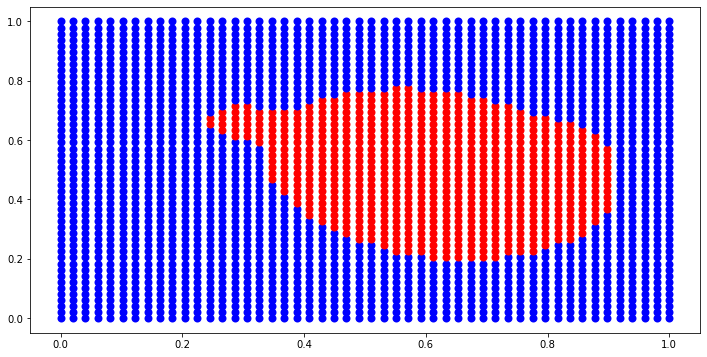

In [6]:
a=0.3
n= 4



g,s = ensalea(n,a,1)

In [7]:
def echant(l,g,s):
    x=np.random.uniform(0,1,(l,2))
    x1=x[:,0]
    x2=x[:,1]
    Y = intens(x1,x2,g,s)
    return x1,x2,Y

In [8]:
def isinC_ij(x1,x2,i,j,p):                                      #Pour savoir si un point appartient au carreau C_ij
    x,y = x1,x2
    if ((i-1)/p <= x) and (x<= i/p) and ((j-1)/p <= y) and (y<= j/p) :
        return 1
    else :
        return 0
    
    
def L_ij(X1,X2,Y,i,j,p):                                         #Calcule le l+ et l- pour un carreau C_ij donné
    l_plus = 0
    l_moins = 0
    for k in range (len(X1)):
        if (isinC_ij(X1[k],X2[k],i,j,p) == 1) and (Y[k] == 1):
            l_plus += 1
        elif (isinC_ij(X1[k],X2[k],i,j,p) == 1) and (Y[k] == -1):
            l_moins += 1
    return l_plus, l_moins
        

La fonction ```estens``` renvoie une matrice B contenant tous les $p^2$ carreaux et permet de trouver tous les $c_{ij}$ carreaux qui participent à la construction de $\hat C_p$. En effet, B(i,j) = 1 si $c_{ij} \in  \hat C_p$ et =0 sinon. La fonction renvoie également le risque $\hat R^*_p$ associé à $\hat C_p$. Ainsi, sur l'échantillon test, on prédira 1 si le $X'_i \in \hat C_p$ et 0 sinon.

In [9]:
def estens(X1,X2,Y,p):                 
    risque = 0
    B = np.zeros((p,p))
    l = len(X1)
    for i in range (p):
        for j in range(p):
            l_plus, l_moins = L_ij(X1,X2,Y,i+1,j+1,p)
            if (l_plus >= l_moins) :
                B[i,j] = 1
                risque += l_moins
            else : 
                B [i,j] = 0
                risque += l_plus
    risque /= l
    return  B, risque


            
            


On peut maintenant construire la fonction ```testens``` qui va utiliser l'échantillon d'apprentissage pour prédire sur l'échantillon test et ainsi calculer le risque $R_{test} (\mathbb {1} _{\hat C_p})$ associé. Ce risque test va approximer le vrai risque $R (\mathbb {1} _{\hat C_p})$ à partir d'une certaine taille $m= \lceil-\frac {log(0.05/2)} {2*0.02^2}\rceil$

In [11]:
def testens(B,m,g,s):
    X1,X2,Y = echant(m,g,s)
    p=B.shape[0]
    risque = 0
    for i in range(p):
        for j in range(p):
            if B[i,j]==1:
                risque += L_ij(X1,X2,Y,i+1,j+1,p)[1]
            else:
                risque += L_ij(X1,X2,Y,i+1,j+1,p)[0]
    risque /= m
    return risque
                
            

In [58]:
def affichage_erreur(l):
    m=int(np.ceil(-(np.log(0.05/2))/(2*(0.02)**2)))
    X1,X2,Y = echant(l,g,s)
    Rp = []
    Rtest = []
    for p in range (2,60):
        B,R = estens(X1,X2,Y,p)
        Rp += [R]
        Rtest += [testens(B,m,g,s)]
    
    pmin = Rtest.index(min(Rtest))  + 2
    print("Pour l = {} le p optimal vaut {}".format(l,pmin))
    plt.plot(np.arange(2,60),Rp, label = ' Empirique')
    plt.plot(np.arange(2,60),Rtest, label = ' Test')
    plt.title("l ={}".format(l) )
    plt.legend()
    plt.show()

Pour l = 100 le p vaut optimal 5


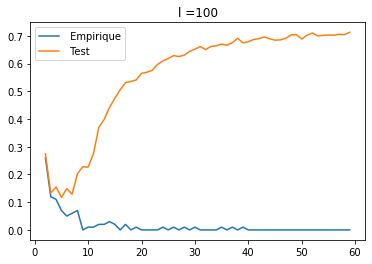

In [59]:
affichage_erreur(100)

Pour l = 500 le p vaut optimal 9


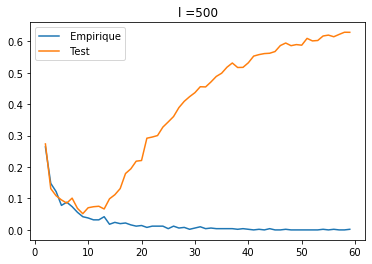

In [60]:
affichage_erreur(500)

Pour l = 1000 le p vaut optimal 12


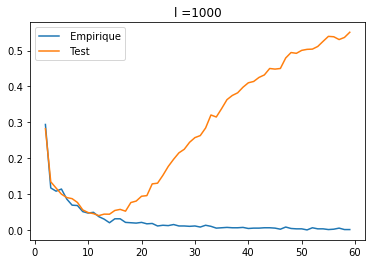

In [72]:
affichage_erreur(1000)

Pour l = 10000 le p vaut optimal 36


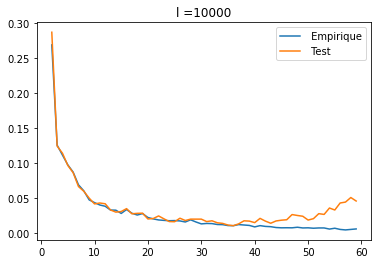

In [73]:
affichage_erreur(10000)

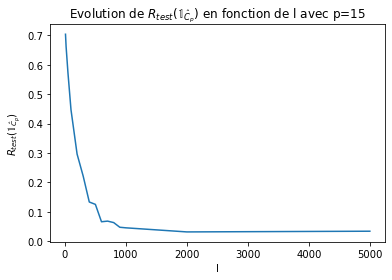

In [66]:
#On fixe p= 15

p=15
lst=[10,20,50,100,200,300,400,500,600,700,800,900,1000,2000,5000]
m=int(np.ceil(-(np.log(0.05/2))/(2*(0.02)**2)))
Rtest = []

for l in lst:
    X1,X2,Y = echant(l,g,s)
    B,R = estens(X1,X2,Y,p)
    Rtest += [testens(B,m,g,s)]

plt.plot(lst,Rtest)
plt.xlabel("l")
plt.ylabel("$R_{test} (\mathbb {1} _{\hat C_p})$")
plt.title("Evolution de $R_{test} (\mathbb {1} _{\hat C_p})$ en fonction de l avec p=15")
plt.show()
    


Pour p=15, on constate un "coude" aux alentours de l=1000, cela signifie que le l optimal à choisir est de 1000, l'augmenter ne servirait à rien et le diminuer donnerait de moins bons résultats.

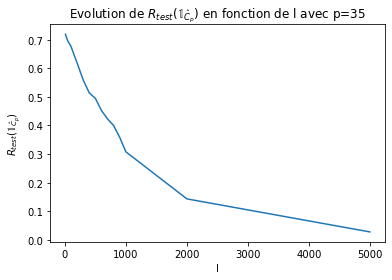

In [71]:
p = 35
Rtest =[]
for l in lst:
    X1,X2,Y = echant(l,g,s)
    B,R = estens(X1,X2,Y,p)
    Rtest += [testens(B,m,g,s)]

plt.plot(lst,Rtest)
plt.xlabel("l")
plt.ylabel("$R_{test} (\mathbb {1} _{\hat C_p})$")
plt.title("Evolution de $R_{test} (\mathbb {1} _{\hat C_p})$ en fonction de l avec p=35")
plt.show()
    

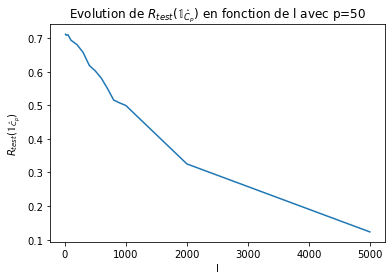

In [68]:
p = 50
Rtest =[]
for l in lst:
    X1,X2,Y = echant(l,g,s)
    B,R = estens(X1,X2,Y,p)
    Rtest += [testens(B,m,g,s)]

plt.plot(lst,Rtest)
plt.xlabel("l")
plt.ylabel("$R_{test} (\mathbb {1} _{\hat C_p})$")
plt.title("Evolution de $R_{test} (\mathbb {1} _{\hat C_p})$ en fonction de l avec p=50")
plt.show()
    


Pour p=50, il faut un l>5000, pour obtenir les meilleurs résultats possibles.